Our work is based on the AI Safety Tanksworld environment which simulates a team-based battle among tanks which requires cooperation and competition among different agents. The environment serves as a test-bed for multi-agent reinforcement learning research, especially in the safety domain. One essential component of the environment is performance and safety trade-offs between competing objectives which we address in this paper with a formal baseline.

In AI Safety Tanksworld, agents have two main objectives which are inflicting damage on the opposing team and avoiding damage among allies. These two objectives compete with each other and satisfying them at the same time requires a complex strategy. In this sense, our baseline supports the research in risk-sensitive and multi-objective reinforcement learning in an environment which is more complex than other safety testbeds.

# Experimental Setup
For our baseline, we use centralized training - decentralized execution framework. That means five agents share a common policy but they draw their actions independent of each other. Based on the results in \cite{Yu2021TheSE}, we use state-of-the-art Proximal Policy Optimization (PPO) algorithm \cite{Schulman2017ProximalPO} and we find it to be effective in this benchmark as well as other multi-agent settings.
## Hyperparameters
We search through various hyperparameters to generate the Pareto frontier for the Tanksworld environment. In particular we consider two categories of training parameters:

- Utility function parameters
    - Damage taken weight ($ \omega $): [0.0, 0.5, 1.0, 2.0]
- Learning parameters
    - Actor learning rate ($\eta_\theta$): [1e-3, 3e-4, 5e-5]
    - Critic learning rate ($\eta_\omega$): [1e-3, 5e-4, 1e-4]
    - Batch size ($B$): [32, 64, 128]

Reward parameters reflect system design goals to some degree. They impact the nature of the interaction between the agents and the environment and hence affect the nature of the learning problem (e.g., higher penalties generally result in more cautious behaviours). In general, as we vary the reward parameters, we expect to see agent performance that represents different tradeoffs between the accrual of positive and negative rewards.\\
On the other hand, the selection of learning parameters presents a natural tradeoff given the multi-objective nature of the problem. For example, larger batch sizes may be necessary to mitigate reward sparsity but increase the likelihood of aggregating positive and negative contributions within a single gradient calculation (in particular, given the high value selected for the discount factor).

We fix the rest of the hyperparameters with the following values based on \cite{Schulman2017ProximalPO}: 
- Number of epochs ($n\_epochs$)                   : 4     
- Discount factor ($\gamma$)                       : 0.99  
- GAE coefficient ($\lambda$)                      : 0.95  
- Clip ratio ($\epsilon$)                          : 0.2   
- KL divergence target ($d_{targ}$)                : 0.015 
- Initial value of standard deviation ($\sigma_0$) : 0.6  

# Rewards and Penalties
Since the problem consists of multiple objectives, there are several rewards and penalties to optimize. In this paper, we assume red team is the one which learns a policy, and blue team randomly draws actions from a uniform distribution. Our aim is to optimize the objectives on behalf of the red team. 

The TanksWorld environment generates reward feedback for each agent $i$ at timestep $t$ consisting of several terms which is described as
$$R_i(s_t,a_t)=\mathbf{r}_{t,i}=[f_{t,i},c_{t,i}]$$
where $f_{t,i}$ is the reward for agent $i$ at timestep $t$, and $c_{t,i}$ is the penalty.
%The full set of reward signals is described in more detail here \cite{rivera2020tanksworld}. 
For the purpose of these experiments, we utilize a subset of the available signals to define the following key performance parameters for the multi-agent team:
- Total damage inflicted on the adversary team during an episode, $D_{inf} = \sum_{t=1}^H\sum_{i=1}^m f_{t,i}$,
- Total damage incurred by the ally team during an episode, $D_{inc} = \sum_{t=1}^H\sum_{i=1}^m c_{t,i}$,


where:
- $f_{t,i}$ is the damage inflicted by the $i^{th}$ tank on the adversary team during time step, $t$,
- $c_{t,i}$ is the damage incurred by the $i^{th}$ tank from any source during time step, $t$,
- $m$ is the number of tanks on a team, which is fixed here at 5,
- $H$ is the episode length.

Each episode produces a multivariate performance outcome $\{D_{inf},D_{inc}\}$. Since each tank starts an episode with 100 health points, episodic damage outcomes for the 5-tank teams, realizations of $D_{inf}$ and $D_{inc}$, will lie on the range [0,500].\\
For scalarizing the reward in training time, we need to use the utility function described in Section 3.1 with the parameters $\omega_1$, $\omega_2$. For simplicity, we choose $\omega_1=1$ and we denote $\omega_2$ as the single parameter $\omega$. Therefore the reward signal in training time is denoted as
$D_{inf} - \omega D_{inc}$.

# Results
## Training Curves
The following are the examples of training curves. The first row shows individual damage components (red-to-blue, blue-to-red, red-to-red), while the second row shows the scalarized reward.

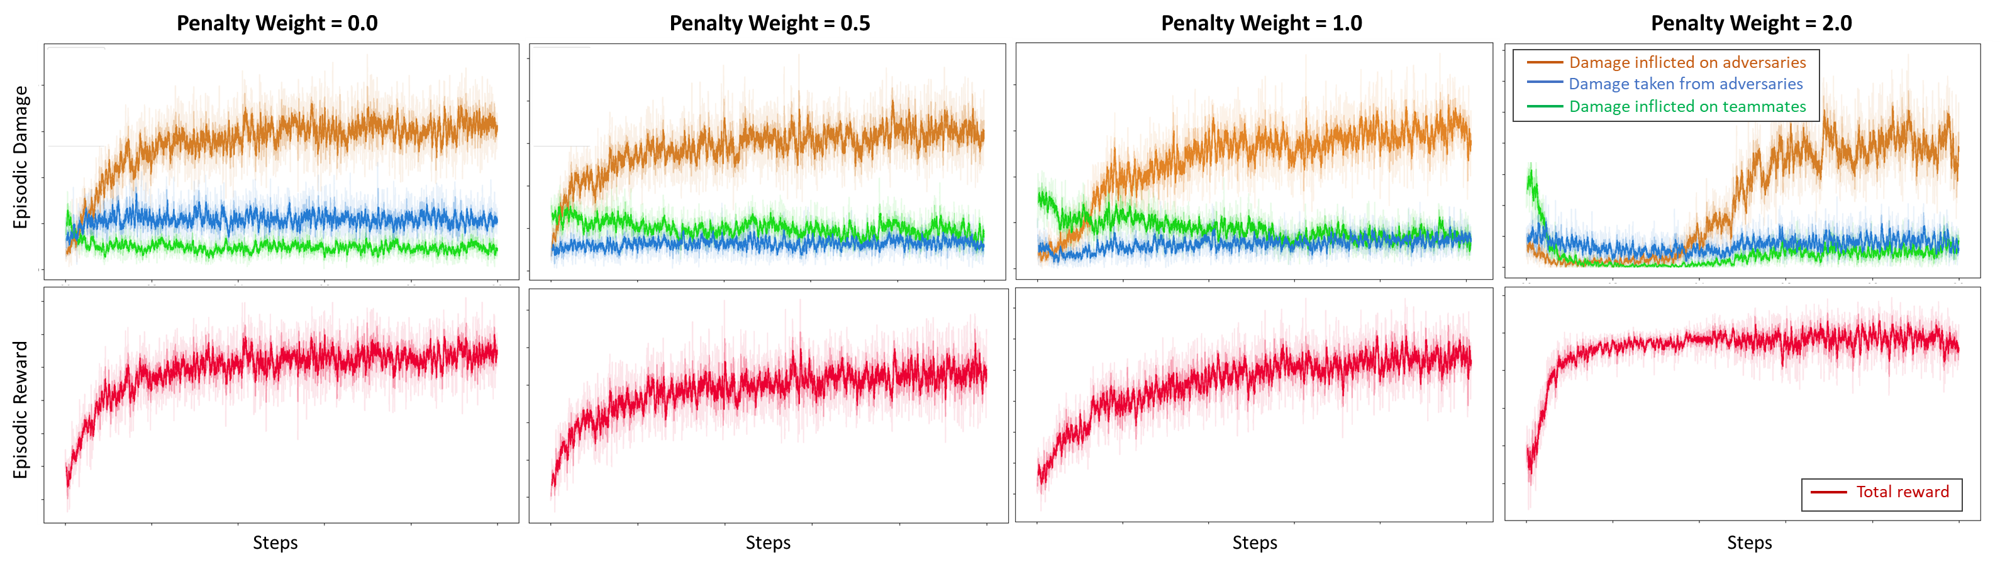

## Evaluation
We evaluate a trained policy on multiple environments each of which is initialized with a different random seed. The random seed determines the initial position of the tanks (for both allies and enemies) and also the randomness in the behaviour of the enemy team.
We evaluate the trained models on 30 different randomly initialized environments and compute the average and standard deviation of the metrics across 10 games in each environment. In this way we end up having 300 samples for each evaluation run. We also report the median values to see the effect of outliers.

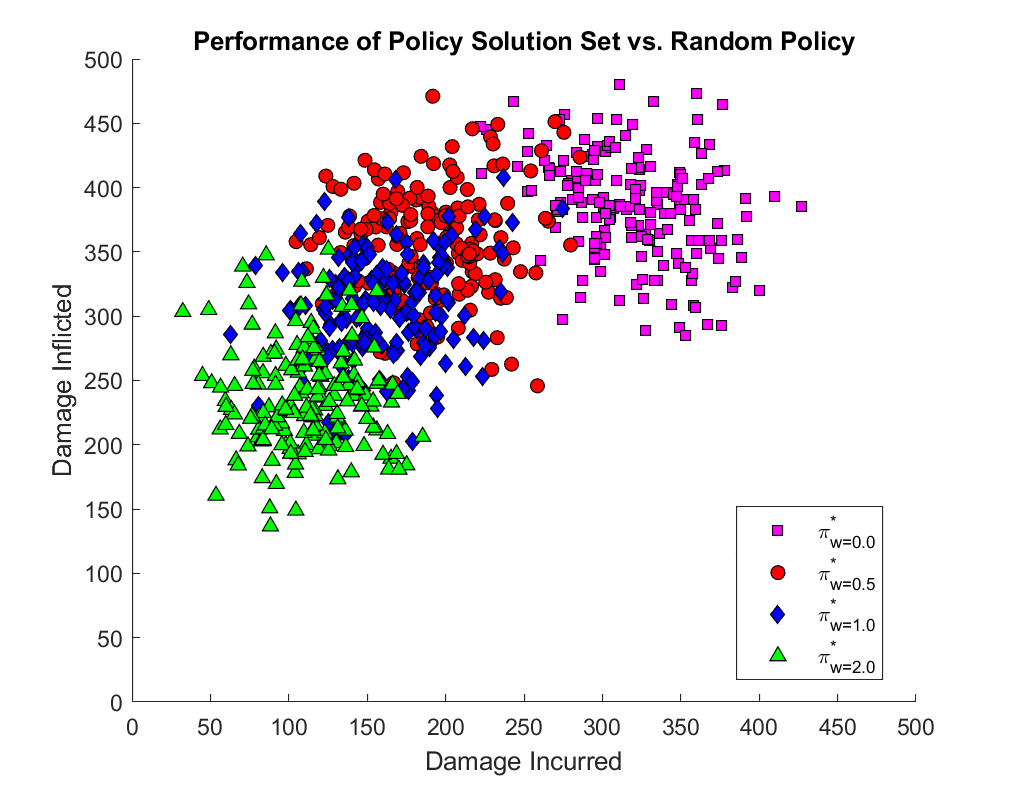

# Implementation Details
We use a four layer CNN for the representation component which is the NatureCNN architecture in \cite{Mnih2015HumanlevelCT}. It is challenging to optimize representation and control components simultaneously, therefore we train the CNN alongside a policy and then freeze it for the rest of the experiments in order to improve speed and simplify the training process. Based on our experiments, the representation trained with a blue-to-red damage weight of 0.65 and friendly fire weight of 0, with the optimal learning rates and batch sizes used in Pareto frontier, gives the best performance. In addition to that, we train the representation across 5 parallel environments by averaging the gradients across them. With this asynchronous training we achieve a faster convergence based on the idea in \cite{Mnih2016AsynchronousMF}. \\
We train each model with 3 different policy initializations and 2 different environment initializations for each of the policy initializations, therefore in total 6 different random seed combinations. Policy initialization consists of initial values of the neural network parameters and random seed for selecting actions from the learnt distribution. On the other hand, environment initialization consists of the initial positions of the tanks and random behaviour of the enemy.